# Resilience Statistics for Soft Faults
We run experiments on how well various resilience strategies are able to correct soft faults by manually flipping bits and checking if the correct solution is recovered.
Let's introduce all the concepts with the [Van der Pol](https://github.com/Parallel-in-Time/pySDC/blob/master/pySDC/implementations/problem_classes/Van_der_Pol_implicit.py) equation.
To keep this notebook tidy, we wrote a class that contains functions for generating and processing statistics, which we first need to set up. Don't worry about the parameters for now, we will explain them as we go along.

In [1]:
from fault_stats import FaultStats, BaseStrategy, AdaptivityStrategy, IterateStrategy, HotRodStrategy, run_vdp
import matplotlib.pyplot as plt
import numpy as np
import pySDC.helpers.plot_helper as plot_helper
plot_helper.setup_mpl(14, True)
plot_helper.mpl.rcParams['figure.dpi'] = 300

vdp_stats = FaultStats(prob=run_vdp, faults=[False, True], reload=True, recovery_thresh=1.1, num_procs=1, mode='combination',
                       strategies=[BaseStrategy(), AdaptivityStrategy(), IterateStrategy(), HotRodStrategy()])

vdp_stats.run_stats_generation(step=50)

## How do we insert faults?
We restrict ourselves to inserting faults in the solution at a specific simulation time, but then we have only a limited number of combinations of collocation nodes, iterations, bits and problem positions available.
Since are dealing with an ordinary differential equation, there are few "spatial" degrees of freedom and the variable with the most possible entries is the bit (64 allowed values) in which the fault happens.

In [2]:
print(f'In the van der Pol example, we have {vdp_stats.get_max_combinations()} possible combinations where a fault could happen for a given time')

In the van der Pol example, we have 1536 possible combinations where a fault could happen for a given time


That is not so bad! We can easily just try all of those!

We pick a time where something happens so that the potential impact of the faults is big and we put faults in at the same time $T_\mathrm{fault}$ in the simulation in every run.

Since we put in only single faults here, we neglect that the less computationally expensive the simulation is, the more resilient it is, because probability of a fault scales with the physical size of the system that we use and with the time that we run on it.
This is a direct consequence of Murphy's law, which states that the probability of a failiure is proportional to the number of opportunities for a failiure.
If you take a bike ride from Jülich to Cologne, you will probably be fine, but if $10^6$ people ride their bikes from Jülich to Vienna, the probability that one of them will fall over is extremely high.

## What resilience strategies do we look at?
We test the following strategies:
 - base: Fixed iteration count and fixed step size
 - adaptivity: Fixed iteration count and adaptive step size
 - iterate: Adaptive iteration count and fixed step size
 - Hot Rod: Fixed everything, but detector on top

What sort of resilience do we expect from these strategies?

### Base scheme
Well, the base scheme does nothing to prevent faults, but a lot of faults don't really impact the solution and some have no impact at all.
When using a set of quadrature nodes, where the right node corresponds to the interface, for instance, all faults occuring in the last iteration in any but the interface node do not impact the solution, which is
$$
\frac{1}{N_\mathrm{iter}}\times\frac{N_\mathrm{coll}-1}{N_\mathrm{coll}} = \frac{1}{3}\times\frac{3}{4}= 25\,\%
$$
in our van der Pol example, so actually quite a significant amount!

Also, we solve the problem only to limited precision and perturbing the solution below this precision has no impact on the outcome as well.
We use `numpy.ndarray` to store the solution, which stores the individual floating point numbers in a 64 bit format by default.
The error of the fault-free runs, which we compute with a scipy reference solution, is on the order of $10^{-6}$ and the precison of the double implementation goes down to about $10^{-11}$, so you can imagine that there are many bits which change the solution by less than we care about.

### Adaptivity
This scheme will restart the current step whenever an estimated error exceeds some predefined tolerance.
See [this notebook](https://github.com/Parallel-in-Time/pySDC/blob/master/pySDC/projects/Resilience/Adaptivity.ipynb) for details.
The tolerance is either not reached because the step size was too large, or because a fault occurred, both cases will lead to a restart of the step with a refined step size.
Don't worry!
The step size is increased again if we over-resolved the problem, which is the case for fault triggered refinement.

### Iterate
Here, we just set a residual tolerance and iterate until we reach it or until we reach 99 iterations, at which point we get impatient and move on no matter the state of the solution.
This works well in fixing smaller faults, but it does struggle a bit with larger faults.
A potentially more efficient strategy would be to restart if the residual threshold was not reached after a maximum amount of iterations.


### Hot Rod
[Hot Rod](https://doi.org/10.1007/978-3-319-43659-3_47) is a detector for soft faults that was developed in the context of explicit Runge-Kutta methods, but as they mention in the paper, it can easily be implemented in other methods as well.
See [this notebook](https://github.com/Parallel-in-Time/pySDC/blob/master/pySDC/projects/Resilience/HotRod.ipynb) for some explanations. 

### Faults we cannot fix
We have a large problem when the fault hits the initial conditions of a step, a.k.a. collocation node zero in the implementation in pySDC.
We may still converge to the solution of some problem, but it's not the problem we set out to solve!
In our example, this corresponds to
$$
\frac{1}{N_\mathrm{coll}}=\frac{1}{4} = 25\,\%
$$
of faults.
You might find some solace in that not all of them are actually bad.
If you have a fixed iteration count, such faults occuring in the last iteration fall under the no-impact category discussed in the base scheme, so for a fixed iteration scheme, we get only
$$
\frac{1}{N_\mathrm{coll}}\times\frac{N_\mathrm{iter}-1}{N_\mathrm{iter}}=\frac{1}{4} \times \frac{2}{3} \approx 16\,\%
$$
uncorrectable faults.
Additionally, quite a bit (in our case about half) are insignificant because they hit mantissa bits that we don't care about.

### How do the strategies compare without faults?
<a id='efficiency'></a>
The strategies mess with the overall scheme quite a bit so we want to make sure we solve the problem to similar accuracy and we want to know what the computational cost is for each scheme to reach this accuracy.
The two quantities that we look at are the local error $\epsilon$ and iteration counts.

We compute the local error with `scipy.solve_ivp`, where we solve the problem for a single time step to very low tolerances to approximate the true solution.
We have to do this because no analytic solution is available for the van der Pol equation, but we convinced ourselves in the [Hot Rod notebook](https://github.com/Parallel-in-Time/pySDC/blob/master/pySDC/projects/Resilience/HotRod.ipynb#order) that this works well enough.

As a unit for the computional cost, we use the iteration count since the iterations are the most expensive part of the computation.
Actually, we make a simplification here, because we do not look at the Newton iterations, but at the SDC iterations, meaning we assume the cost of an SDC sweep to be constant, while it does not have to be.

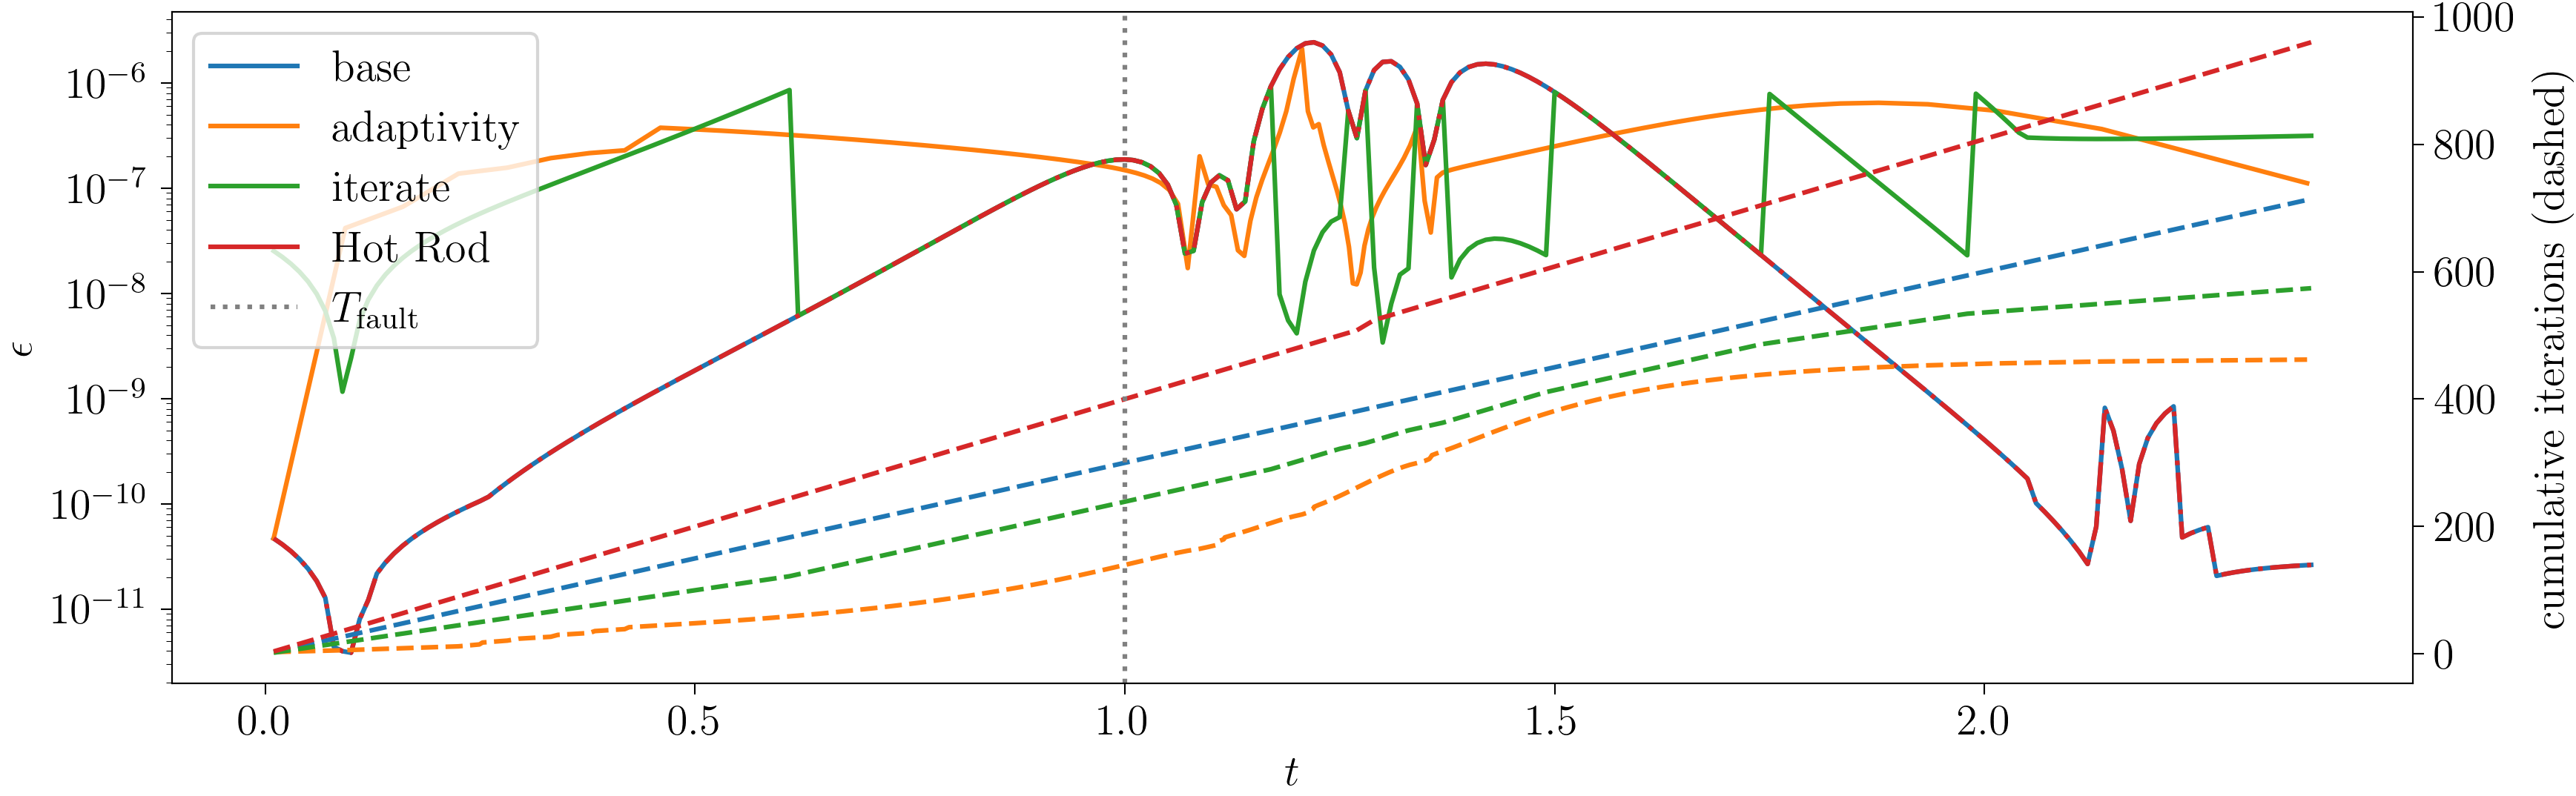

In [3]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
vdp_stats.compare_strategies(ax=ax)
k_ax = ax.get_shared_x_axes().get_siblings(ax)[0]
k_ax.axvline(1., label=r'$T_\mathrm{fault}$', color='grey', ls=':')
_ = k_ax.legend()

#### What accuracy do the schemes have?
The time scale of the problem has three phases: Initially, the oscillation is slow, then it is fast and then it slows down again.
If we solve the problem with the same parameters throughout, we are going to get very high accuracy in the beginning and end to get the accuracy we need in the middle.
Of course, over-resolving parts of the simulation does not come with any benefit.
If the global error is already large at some step, that is to say the initial conditions are inaccurate, solving the time step really well still gives an inaccurate solution to the initial value problem.

From the above plot we can see, that there are actually many orders of magnitude between the local error in the fast moving middle part and the slower parts for the base scheme.
To make sure we get similar accuracy overall, we set up the schemes in a way that the maximum local error is the about the same.

From this plot, we can evaluate the adaptive resolution capabilities of each scheme.
The base and Hot Rod schemes have no adaptive resolution in time, which leads to the huge discrepancies in local error between $10^{-11}$ and $10^{-6}$.
The iterate strategy on the other hand gives much lower variations, but there are large jumps in the local error whenever the iteration number between two steps jumps up or down.
While we get some adaptive resolution here, the fact that the iteration number is an integer (ranging from 1 to 4 in this case) means we get only coarse refinement.

Adaptivity on the other hand controlls the step size, an arbitrary floating point number.
While the first step is over-resolved since we started with the same step size as the other schemes, the step size is de-refined in the next step to something more sensible.
As discussed in the [adaptivity notebook](https://github.com/Parallel-in-Time/pySDC/blob/master/pySDC/projects/Resilience/Adaptivity.ipynb#adaptivity), there is some heuristics involved, which means we don't get exactly the optimal step size for our target resolution, but the curve is the most flat of the strategies that we consider here.

#### How efficient are the schemes?
While we don't gain anything from over-resolving, it does not not hurt the solution, but how much effort are wasting by this?
We see that the base and Hot Rod have straight lines in the iteration plot, with slope equal to iterations per step.
However, the Hot Rod scheme needs one more iteration per step to get the same accuracy, in order to match the error estimates.
The other two schemes, on the other hand, trace a curve where the slope corresponds to the time scale of the problem and is not constant.
Eventually, using Hot Rod is twice as computationally expensive as adaptivity in this particular test.

Notice that allowing adaptive resolution gives us the same accuracy in fewer iterations, which is a good thing regardless of faults.
Or goal here is not just to fix all faults, since replication already exists and can be near perfectly resilient.
Since our hope is to find a resilience strategy that is less expensive than replication but similarly resilient, we would be very satisfied if our resilience strategies would actually reduce the computational cost of the scheme.

Let's set the scene for our experiments before we see if we can have our cake and eat it, too.

## How to decide whether a fault is recovered?
Unfortunately, there is no natural criterion for recovery of a fault.
What we decided to do is estimate the error at the end of the run and compare it to the error that we would get if no fault had occurred.
Since we solve the problems to limited accuracy, we give some leeway and we accept if
$$
e \leq \gamma e^*,
$$
where $\gamma \geq 1$ is the acceptance threshold and $e$ and $e^*$ are the errors of the run with faults and without faults respectively.
But what is a good value for $\gamma$?
We can make a plot how this changes the overall recovery rate and decide on a problem-specific basis:

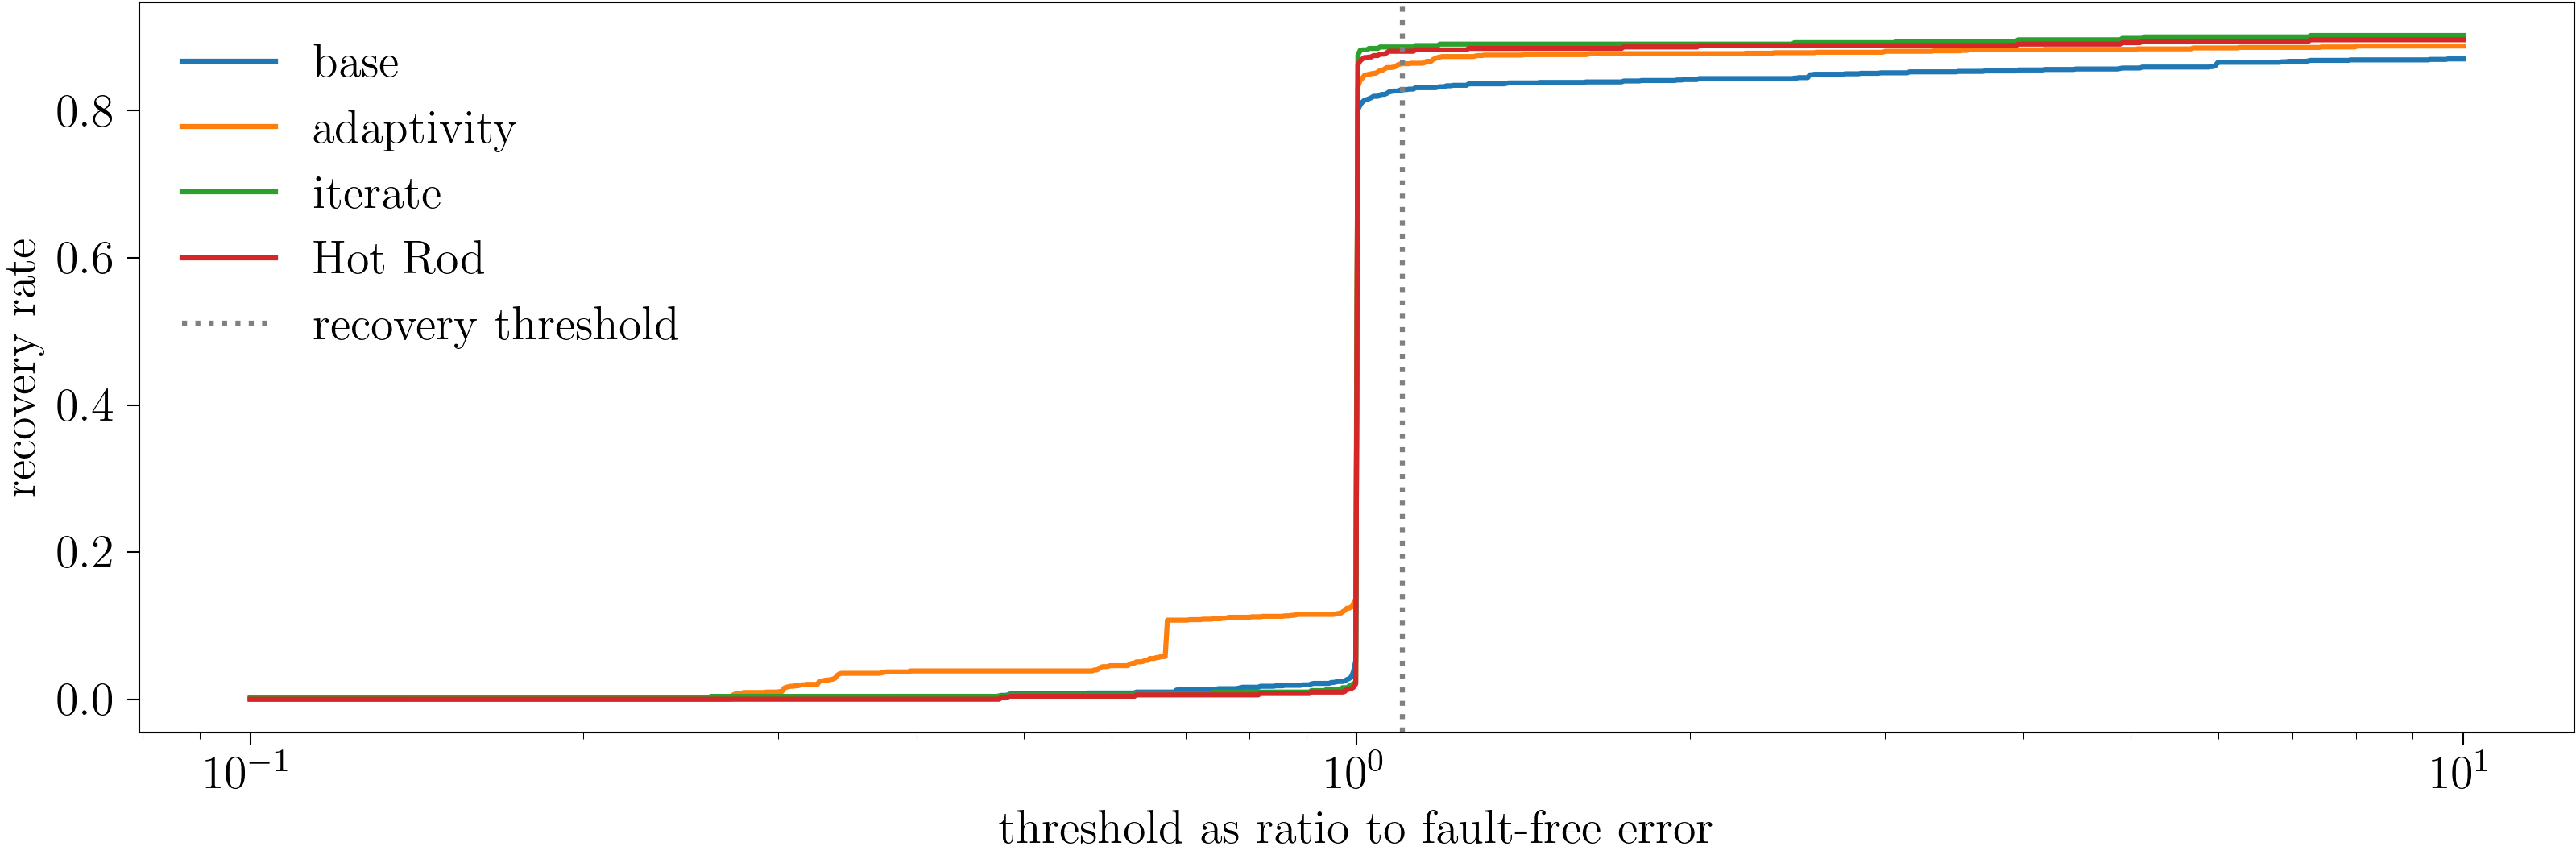

In [4]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
vdp_stats.plot_recovery_thresholds(ax=ax, thresh_range=np.logspace(-1, 1, 1000))
ax.axvline(vdp_stats.recovery_thresh, color='grey', ls=':', label='recovery threshold')
ax.set_xscale('log')
ax.legend(frameon=False)
plt.show()

You can see that, again, there is no obvious value we can read off of this plot, but we decide to be pretty strict and choose $\gamma=1.1$ as our recovery threshold here.

## Which faults are recovered?
We can now make some plots of the recovery rate depending on where the faults hit.

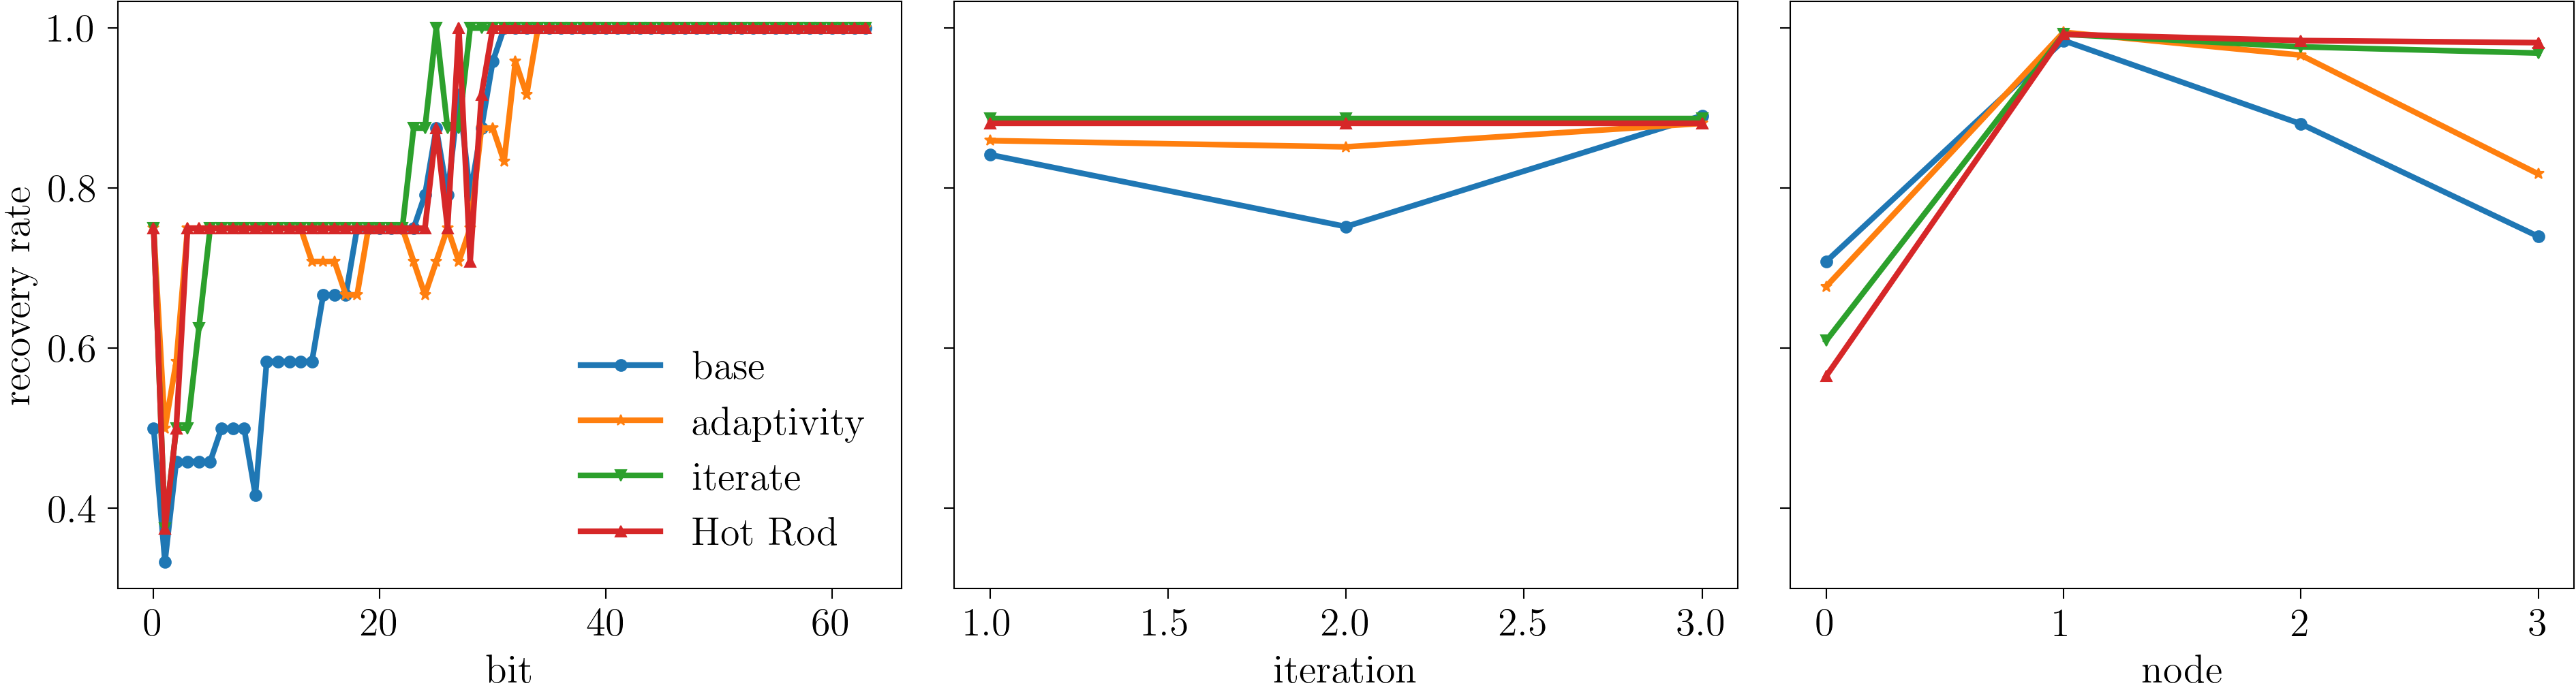

In [5]:
def plot_stuff(stats, op, ylabel=None, mask=None, suptitle='', thingA='bit'):
    fig, axs = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
    args = {'ylabel': ylabel} if ylabel is not None else None
    stats.plot_things_per_things(thingA=thingA, thingB='bit', op=op, args=args, ax=axs[0], mask=mask)
    stats.plot_things_per_things(thingA=thingA, thingB='iteration', op=op, args={'ylabel': ''}, ax=axs[1], mask=mask)
    stats.plot_things_per_things(thingA=thingA, thingB='node', op=op, args={'ylabel': ''}, ax=axs[2], mask=mask)
    axs[1].get_legend().remove()
    axs[2].get_legend().remove()
    fig.suptitle(suptitle)
    fig.tight_layout()

plot_stuff(vdp_stats, op=vdp_stats.rec_rate, ylabel='recovery rate')

In the above plots, we can read off a few things that determine how bad a fault is:
 - Flipping mantissa bits beyond about 30 does not impact the simulation
 - "Later" collocation nodes are more likely to cause trouble for the base scheme
 - Other resilience schemes don't really care in which node or iteration the fault has happened
 - Adaptivity struggles with faults in the last node, which is due to an implementation detail we will discuss later
 - However, node 0 faults (which actually hit the initial conditions) are the least likely to be recovered

Great!
This is exactly what we expected!
The only slightly odd observation is that we would expect the base strategy to do better with faults to early iterations, but this does not seem to be the case.

We do, however struggle to identify a clear winner.
The base strategy is worse in terms of resilience, but the other strategies appear very close to each other.
Let's look a bit closer!

One of the major things that people are scared about when it comes to faults is SDC.
Wait, I don't mean spectral deferred corrections, I mean silent data corruption, which shares the acronym by coincidence.

Silent data corruption is a fault in your simulations that is not obvious and just flies under the radar, but then the final simulation result will be perturbed and you can never really be sure whether you just simulated some astonishing physics or whether the cosmos was just particularly malevolent to you that day.
Of course you can check by rerunning the simulation because faults are a random process from your point of view, but we want to avoid pure replication because it is very expensive.

While this aside may help motivate this project, the point we actually want to make here is that there is also the opposite of silent data corruption: Faults that make the code crash.
Since the van der Pol problem is non-linear and we integrate implicitly, we use a Newton solver, which regulaly crashed because of overflow errors.
Let's have a look at what sort of fault leads to a crash:

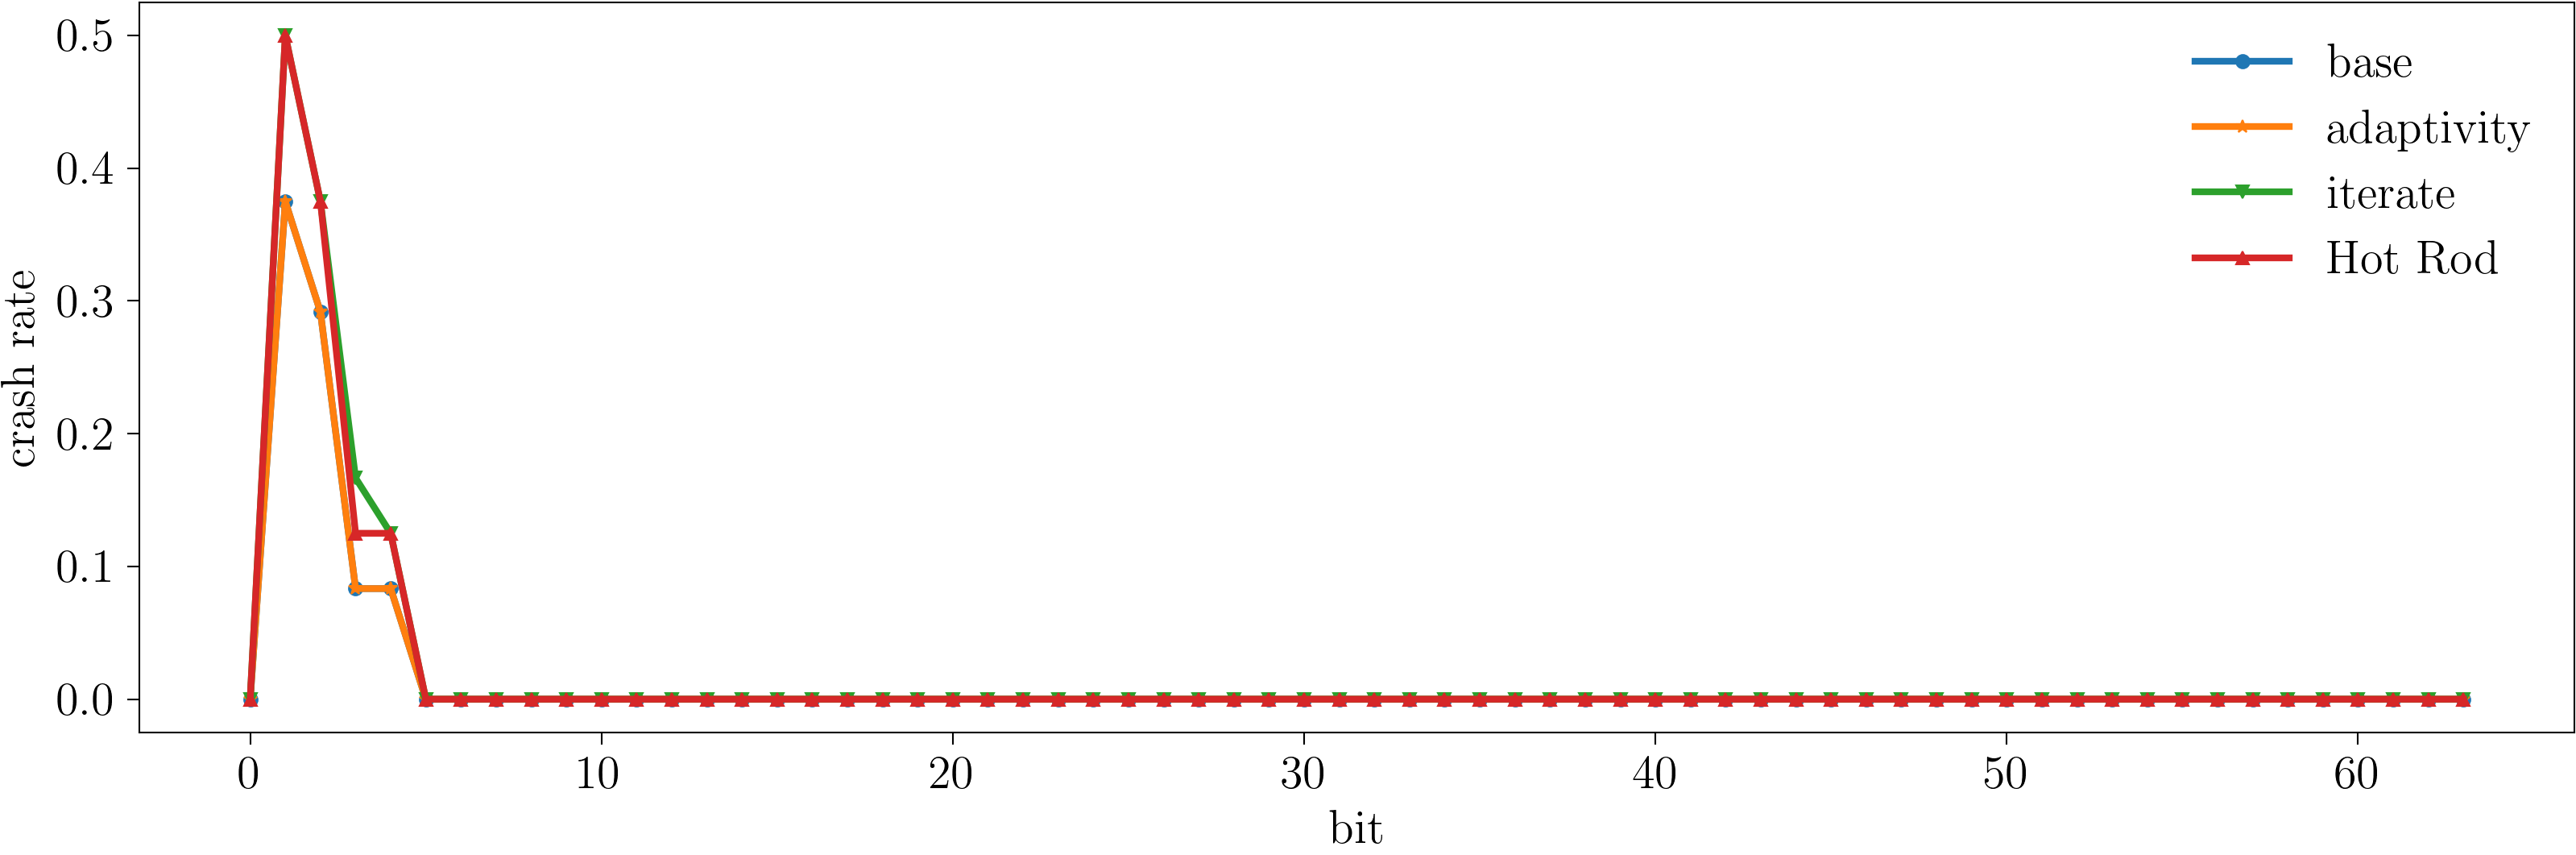

In [6]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
vdp_stats.plot_things_per_things(thingB='bit', op=vdp_stats.crash_rate, args={'ylabel': 'crash rate'}, ax=ax)

Two things become apparent:
 - The strategies all fail at roughly the same faults because after the code has crashed it's game over
 - The bits that cause the code to crash are all in the exponent with bit 1 being our new arch nemesis

Both of these things are expected of course, but are totally problem specific.
We could easily implement a strategy that restarts the step when the solver has failed instead of crashing the code, but since this is a different and not very exciting resilience strategy, we don't implement that here.
Also in some codes the problems are not overflows, like here, but unphysical states like a negative value for density or temperature.
In this case, bit number 0, which encodes the sign might be the most dangerous to flip.

To be a bit more fair to the strategies, we now take a look at all the faults that are in priciple correctible.
We already figured beforehand, that we can't protect the initial conditions without replicating the memory, so we look at faults that happened in other nodes and that didn't make the code crash for any strategy now.

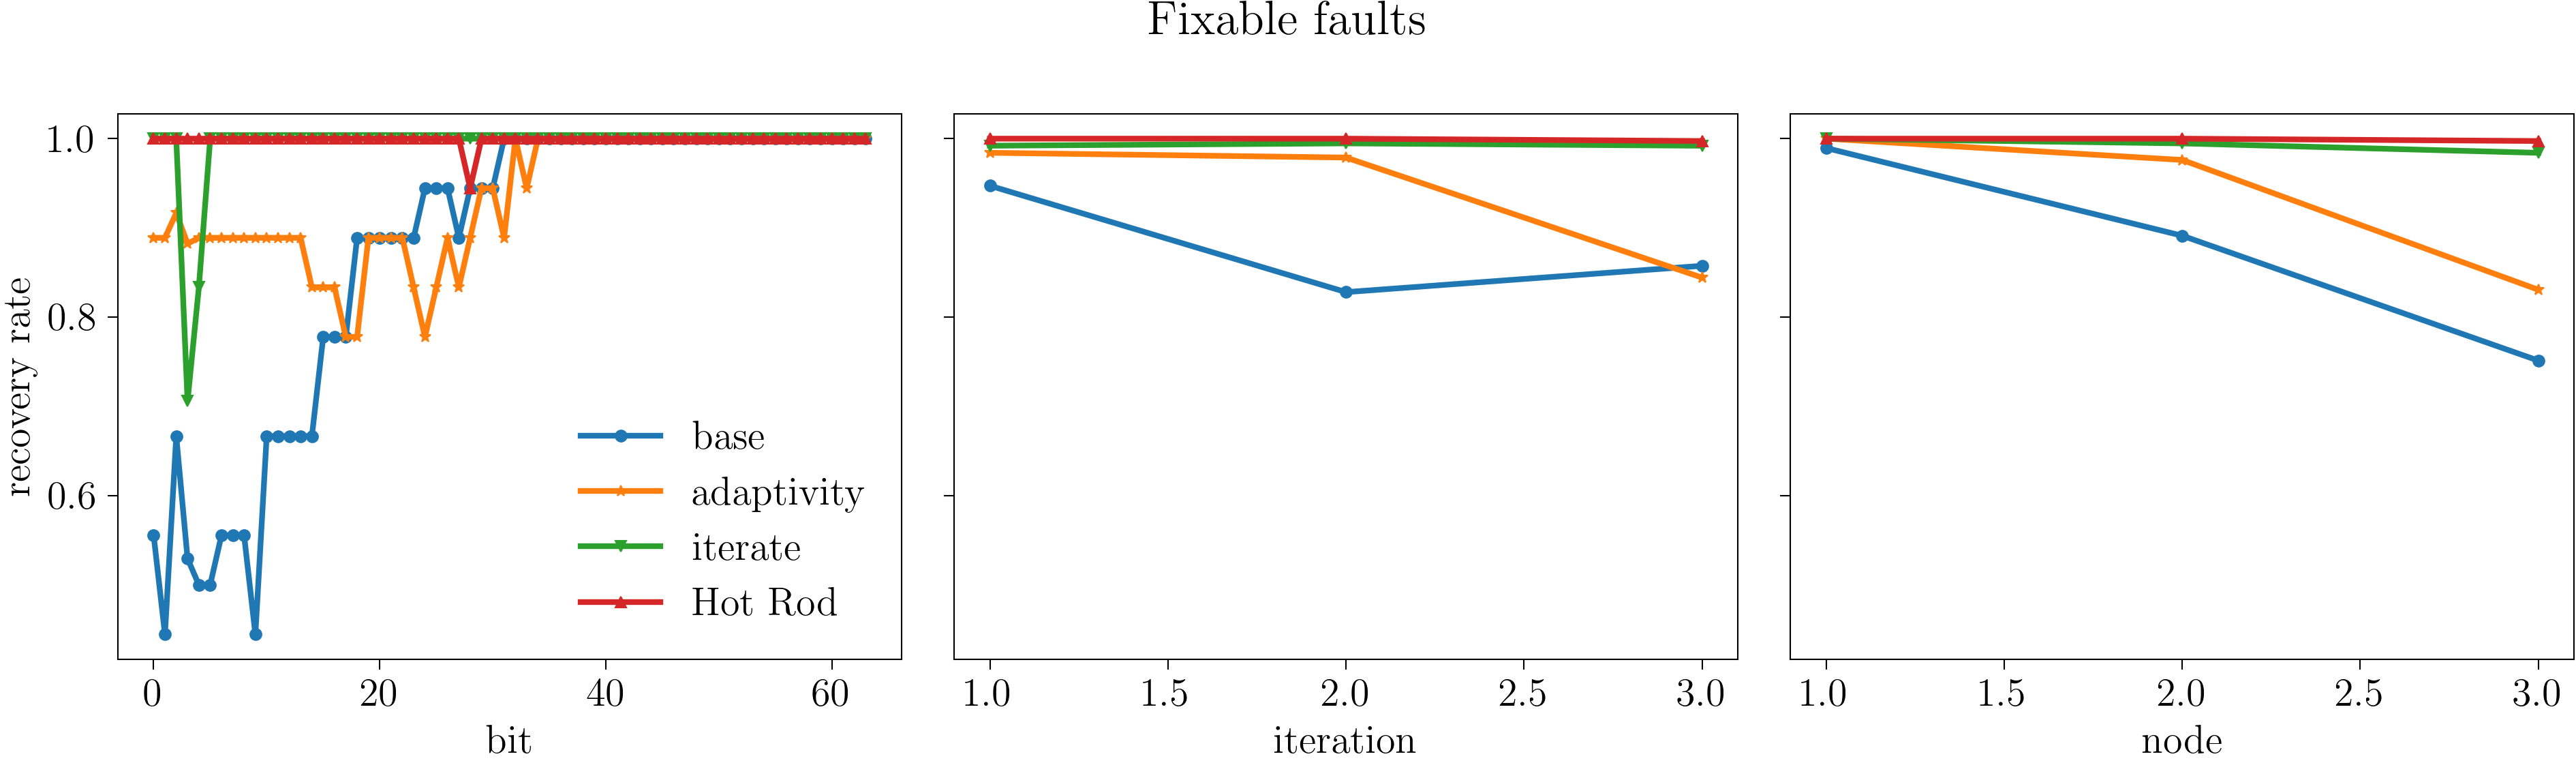

In [7]:
not_crashed = None
for i in range(len(vdp_stats.strategies)):
    not_crashed = vdp_stats.get_mask(strategy=vdp_stats.strategies[i], key='error', op='uneq', val=np.inf, old_mask=not_crashed)
fixable = vdp_stats.get_mask(key='node', op='gt', val=0, old_mask=not_crashed)

plot_stuff(vdp_stats, op=vdp_stats.rec_rate, ylabel='recovery rate', mask=fixable, suptitle='Fixable faults')

Now we can see quite some differences, between the strategies!
Let us look at each of them in detail.

### Iterate
We can see that we fix almost all faults that we can fix by iterating until we reach a residual tolerance, which one would certainly expect since SDC can be interpreted as an iterative solver that converges to a unique fixed point iteration in this case.

However, two things are noteworthy.
First of all, some faults can not get fixed, lets look at what they are:

In [8]:
not_fixed_by_iterating = vdp_stats.get_mask(IterateStrategy(), key='recovered', val=False, old_mask=fixable)
vdp_stats.print_faults(not_fixed_by_iterating)

  run  | bit | node | iter | space pos
-------+-----+------+------+-----------
   806 |   3 |    2 |    1 | [1]
   807 |   3 |    3 |    1 | [1]
   811 |   3 |    3 |    2 | [1]
   814 |   3 |    2 |    3 | [1]
   815 |   3 |    3 |    3 | [1]
   819 |   4 |    3 |    1 | [1]
   823 |   4 |    3 |    2 | [1]
   827 |   4 |    3 |    3 | [1]


All faults that can not be iterated out, but in principle fixed, hit bits three and four in space position `[1]`, which means they hit $p=\dot{u}$.
Now this can easily be explained: After the maximum of 99 iterations, we have not come reasonably close to the fixed point, which is problem specific and apparently caused by flipping a bit in $p$, while flipping a bit in $u$ can be iterated out within 99 iterations.
These faults could probably be corrected by iterating longer, but that seems overly expensive.

What is weird is that none of the bitflips in bits one and two lead to this effect.
Since most faults occuring in these bits make the code crash, we have to assume that this is some problem specific detail caused by the Newton solver somehow.

### Adaptivity
Adaptivity is surprisingly bad at recovering from faults here, what's going on?
Actually, a lot of this is caused by implementation details.
Namely, we insert faults after computing the local error, meaning if a fault hits the last collocation node in the last iteration, we have already computed the embedded error and decided that everything is fine.

Let's take these out of the equation and see what we get:

In [9]:
last_node_last_iter = vdp_stats.get_mask(key='node', op='eq', val=3, old_mask=vdp_stats.get_mask(key='iteration', op='eq', val=3))
not_recovered_by_adaptivity = vdp_stats.get_mask(strategy=AdaptivityStrategy(), key='recovered', val=False, old_mask=fixable)
vdp_stats.analyse_adaptivity(not_recovered_by_adaptivity & (last_node_last_iter==False))

  run  | bit | node | iter |  e_em^*  |   e_em   | e_glob^* |  e_glob  
-------+-----+------+------+----------+----------+----------+----------
   170 |  14 |    2 |    1 | 1.46e-05 | 1.25e-05 | 1.29e-07 | 1.49e-07
   186 |  15 |    2 |    2 | 1.46e-05 | 2.58e-06 | 1.29e-07 | 8.08e-07
   198 |  16 |    2 |    2 | 1.46e-05 | 8.29e-06 | 1.29e-07 | 4.29e-07
   207 |  17 |    3 |    1 | 1.46e-05 | 1.27e-05 | 1.29e-07 | 1.48e-07
   210 |  17 |    2 |    2 | 1.46e-05 | 1.78e-05 | 1.29e-07 | 1.54e-07
   218 |  18 |    2 |    1 | 1.46e-05 | 1.62e-05 | 1.29e-07 | 1.51e-07
   222 |  18 |    2 |    2 | 1.46e-05 | 1.30e-05 | 1.29e-07 | 1.83e-07
  1047 |  23 |    3 |    1 | 1.46e-05 | 1.66e-05 | 1.29e-07 | 1.54e-07
  1058 |  24 |    2 |    1 | 1.46e-05 | 1.61e-05 | 1.29e-07 | 1.51e-07
  1062 |  24 |    2 |    2 | 1.46e-05 | 1.61e-05 | 1.29e-07 | 1.49e-07
  1070 |  25 |    2 |    1 | 1.46e-05 | 1.53e-05 | 1.29e-07 | 1.53e-07
  1099 |  27 |    3 |    2 | 1.46e-05 | 1.61e-05 | 1.29e-07 | 1.51e-07
  11

Still, a significant number of faults is not recovered!
Instead of the problem position, we show here the local error at the end of the steps as well as the global error at the end of the run, where asterisks mark fault free runs and the other columns are with faults.

All of these faults happen in "intermediate" bits, which change the solution only very slightly.
In fact, they change it by so little that we do not exceed the threshold for restarting!
In some cases the embedded estimate is actually reduced slightly by the fault.
However, these small perturbations are not damped out and the final error is slightly out of range of our accepted theshold.

This highlights one flaw of adaptivity as a resilience scheme: There is no way of controlling resilience and accuracy independently.
If we where looking at a chaotic system like the Lorenz attractor, we might run into problems for this reason.
If we look at very diffusive problems, on the other hand, this is not an issue.

### Hot Rod
Hot Rod does not suffer from the implementation order of computing errors and inserting faults like adaptivity does because we perform an extra iteration in Hot Rod, which significantly increases resilience.
Of course, in reality the last iterate can be targeted by a fault just as well as the current iterate, since we store both, meaning that whether this effect at all boosts resilience in a real world scenario is unclear.

But within our fault simulation, Hot Rod fares very will with resilience.
We find, however, a similar effect as with adaptivity in that some smaller faults are not recovered:

In [10]:
not_recovered_by_HotRod = vdp_stats.get_mask(strategy=HotRodStrategy(), key='recovered', val=False, old_mask=fixable)
vdp_stats.analyse_HotRod(not_recovered_by_HotRod)

  run  | bit | node | iter |  e_ex^*  |   e_ex   |  e_em^*  |   e_em   |   diff*  |   diff   | e_glob^* |  e_glob  
-------+-----+------+------+----------+----------+----------+----------+----------+----------+----------+----------
   347 |  28 |    3 |    3 | 1.84e-07 | 1.84e-07 | 1.87e-07 | 4.43e-07 | 2.99e-09 | 2.59e-07 | 1.34e-06 | 1.52e-06
We only restart when diff > tol = 5.00e-07!


In contrast to adaptivity, only one fault falls in this category, because we can put a tighter tolerance on here.
Now this does lead to one step being restarted in the fault free case, since the accuracy changes over the course of the run and we prioritize resilience here by choosing a pretty tight tolerance.
However, this tolerance is still large compared to the tolerance in the fault free case at the time of the fault as the above table shows.

Notice that setting up a tolerance requires us to be quite familiar with the accuracy we have throughout the run.
This can be taken care of, by using adaptivity in combination with Hot Rod, however.

## Conclusions
We inserted faults in the van der Pol problem at a specific point in time and tried recovering from these with different strategies.
It often became apparent that how a resilience scheme fairs is very specific to the implementation of the scheme together with the simulation of faults.
Since we can not control this in the real world, we chose not to select the most resilient implementation in some places, in order to highlight that this is purely an academic exercise.

Instead of giving conclusive results on the resilience capabilities here, we should focus on the integration of these schemes into existing codes.
The iterative scheme is easy enough to implement in a spectral deferred corrections code and provides some adaptive solution in the time direction.
A point can thus be made that this is preferable to iterating a fixed amount in many scenarios.
There are, however, two drawbags: Most time marching schemes like standart Runge Kutta can not be implemented in an iterative way, so this remains pretty specific to SDC and sometimes we need to know the order of the scheme, which changes with the iteration count.

Hot Rod is a strategy derived in the context of Runge-Kutta methods and can be implemented in fixed-order time marching schemes.
It can also be adapted to support changing step sizes.
We again have two drawbacks: Hot Rod struggles with non-linear problems since the extrapolation based estimate is only a heuristic approximation in that case, leading to spurious restarts and Hot Rod adds significant computational cost to the scheme because a solution of higher order than the time marching method needs to be computed.
In the case of SDC, we have to throw away the final sweep, which increased the computational cost relative to the base scheme by 33%.

We want to highlight adaptivity as the winner of this discussion.
While we have not been kind with the implementation details regarding resilience and while Hot Rod can be made to be more resilient (at least for simple problems), adaptivity comes with two major benefits: We gain a lot of computational efficiency, because we can now fine-tune the resolution in time and we can easily implement this into existing codes since estimating the embedded error is just a matter of subtracting two iterates.
What's more, this can be implemented in other time marching schemes as well and is quite established.
In fact, this is implemented in the popular Runge-Kutta 4(5), where stages in the Runge-Kutta scheme are combined to a fourth and a fifth order scheme, which again lets you estimate the embedded error quite easily.

While resilience is an important topic, it does not have to mean you have to add massive overhead to your code.
We believe that adaptivity provides the best compromise between providing good resilience and boosting efficiency, while being easy to implement.
What are you waiting for?
Make your code adaptive today!